Reference: https://github.com/atong01/conditional-flow-matching/blob/main/examples/images/conditional_mnist.ipynb
# Loading library and preparing the dataset

In [ ]:
!pip install torchcfm
!pip install torchdyn
!pip install torchsde
!pip install torchdiffeq

In [4]:
%load_ext autoreload
%autoreload 2
import os

import matplotlib.pyplot as plt
import torch
import torchdiffeq
import torchsde
from torchdyn.core import NeuralODE
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from tqdm import tqdm
import torchvision

from torchcfm.conditional_flow_matching import *
from torchcfm.models.unet import UNetModel

savedir = "models/cond_mnist"
os.makedirs(savedir, exist_ok=True)

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 128
n_epochs = 10

trainset = datasets.MNIST(
    "../data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]),
)

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, drop_last=True
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.6MB/s]


# Configuring the model and training

In [6]:
#################################
#            OT-CFM
#################################

sigma = 0.0
model = UNetModel(
    dim=(1, 28, 28), num_channels=32, num_res_blocks=1, num_classes=10, class_cond=True
).to(device)
optimizer = torch.optim.Adam(model.parameters())
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)
node = NeuralODE(model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

In [22]:
from tqdm import tqdm

for epoch in range(n_epochs):
  loop = tqdm(train_loader, desc=f"Epoch {epoch}", leave=True)
  for i, data in enumerate(loop):
        optimizer.zero_grad()
        x1 = data[0].to(device)
        y = data[1].to(device)

        x0 = torch.randn_like(x1)
        t, xt, ut, _, y1 = FM.guided_sample_location_and_conditional_flow(x0, x1, y1=y)
        vt = model(t, xt, y1)

        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())

Epoch 9: 100%|██████████| 468/468 [01:36<00:00,  4.87it/s, loss=0.119]


# Saving and Loading the model

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Saving the model
torch.save(model.state_dict(), "drive/MyDrive/PIMA/OTCFM_model.pth")

In [ ]:
# Loading the model
# model.load_state_dict(torch.load("drive/MyDrive/PIMA/OTCFM_model.pth", map_location=torch.device('cpu'))) # only when run in cpu
model.load_state_dict(torch.load("drive/MyDrive/PIMA/OTCFM_model.pth"))
model.to(device)

# Testing

testing with random noise generating only images of digit 8

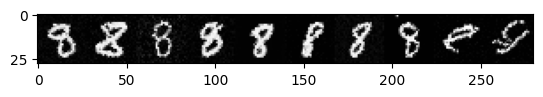

In [23]:
USE_TORCH_DIFFEQ = True
y=torch.tensor([8 for i in range(10)]).flatten().to(device=device)
with torch.no_grad():
    if USE_TORCH_DIFFEQ:
        traj = torchdiffeq.odeint(
            lambda t, x: model.forward(t, x, y),
            torch.randn(10, 1, 28, 28, device=device),
            torch.linspace(0, 1, 2, device=device),
            atol=1e-4,
            rtol=1e-4,
            method="dopri5",
        )
    else:
        traj = node.trajectory(
            torch.randn(10, 1, 28, 28, device=device),
            t_span=torch.linspace(0, 1, 2, device=device),
        )
grid = make_grid(
    traj[-1, :10].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()

Testing with random noise generating images of all labels

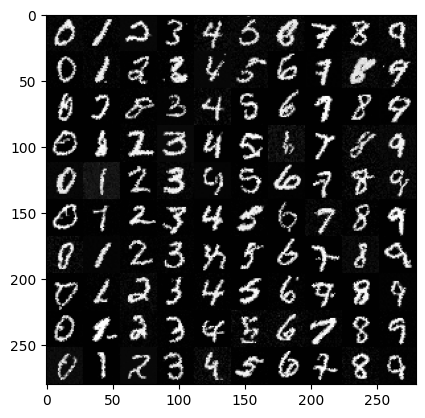

In [5]:
USE_TORCH_DIFFEQ = True
generated_class_list = torch.arange(10, device=device).repeat(10)
with torch.no_grad():
    if USE_TORCH_DIFFEQ:
        traj = torchdiffeq.odeint(
            lambda t, x: model.forward(t, x, generated_class_list),
            torch.randn(100, 1, 28, 28, device=device),
            torch.linspace(0, 1, 2, device=device),
            atol=1e-4,
            rtol=1e-4,
            method="dopri5",
        )
    else:
        traj = node.trajectory(
            torch.randn(100, 1, 28, 28, device=device),
            t_span=torch.linspace(0, 1, 2, device=device),
        )
grid = make_grid(
    traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()

Testing with images of 3 generating images of 8

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm 
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")

x = trainset.data
x = x.unsqueeze(1) # shape: (N, 1, 28, 28)
y = trainset.targets
x_label3 = x[y == 3]
x_label3=x[y==3].to(device)
x_label3 = x_label3.float().to(device) / 255.0  # changing value to range [0, 1]
x_label3 = x_label3 * 2 - 1                            # changing value to range [-1, 1]

# Creating batched DataLoader
BATCH_SIZE = 64
dataset = TensorDataset(x_label3)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)

generated_images = []
USE_TORCH_DIFFEQ = True
for batch in tqdm(dataloader, desc="Generating images"):
    x_batch = batch[0] 
    labels = torch.tensor([8] * x_batch.shape[0], device=device)

    # Generating noisy images with certain timestep 
    t_index = torch.tensor(999, dtype=torch.long, device=device)
    noise = torch.randn_like(x_batch)
    noised_x = noise_scheduler.add_noise(x_batch, noise, t_index)

    # Running ODE
    with torch.no_grad():
        if USE_TORCH_DIFFEQ:
            traj = torchdiffeq.odeint(
                lambda t, x: model.forward(t, x, labels),
                noised_x,
                torch.linspace(0, 1, 2, device=device),
                atol=1e-4,
                rtol=1e-4,
                method="dopri5",
            )
            out = traj[1]
        else:
            traj = node.trajectory(
                noised_x,
                t_span=torch.linspace(0, 1, 2, device=device),
            )
            out = traj[1]

    generated_images.append(out.cpu())

# Concatenating all batches
generated_images = torch.cat(generated_images, dim=0)

Generating images: 100%|██████████| 96/96 [7:20:28<00:00, 275.30s/it]


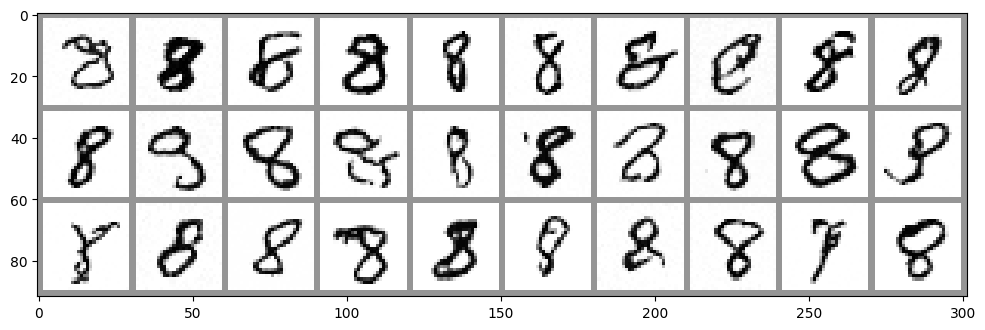

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(generated_images.detach().cpu().clip(-1, 1)[:30], nrow=10)[0], cmap="Greys")

In [9]:
# saving generated images for evaluation later
torch.save(generated_images, "/content/drive/MyDrive/PIMA/generated_images.pt")

In [ ]:
# loading generated images
generated_images = torch.load("/content/drive/MyDrive/PIMA/generated_images.pt")

# Evaluating: Classifier and FID Score
## Classifier

In [ ]:
!pip install tensorflow

In [14]:
# Loading the Classifier model to evaluate
from tensorflow.keras.models import load_model
classifier = load_model("/content/drive/MyDrive/PIMA/Classifier/classifier_model.h5")

In [15]:
# Converting from [-1, 1] to [0, 1] and move to CPU
images_np = ((generated_images.detach().cpu().numpy() + 1) / 2).clip(0, 1)

# Reshaping from (N, 1, 28, 28) to (N, 784)
images_np = images_np.reshape(images_np.shape[0], 784)

images_np = images_np.astype('float32')
print("Input shape:", images_np.shape)

Input shape: (6131, 784)


In [16]:
# Predicting the labels
import numpy as np
predictions = classifier.predict(images_np)
predicted_labels = np.argmax(predictions, axis=1)

print("Predicted labels:", predicted_labels)

192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Predicted labels: [2 8 6 ... 3 8 8]


In [17]:
# Calculating the accuracy
N = len(predicted_labels)
true_labels = np.full(N, 8)
accuracy = np.mean(predicted_labels == true_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 88.09%


### Confusion Matrix

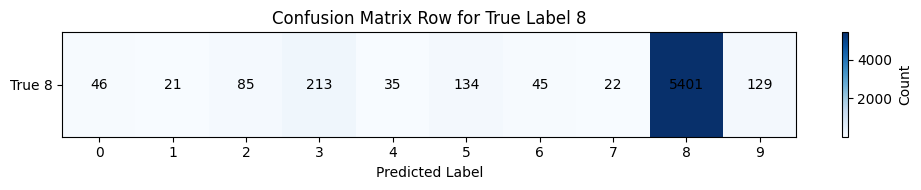

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Computing confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=range(10))

# Extracting row for true label 8
cm_row_8 = cm[8:9, :]  # shape (1, 10)

# Plotting
fig, ax = plt.subplots(figsize=(10, 2))
im = ax.imshow(cm_row_8, cmap="Blues", aspect='auto')

for j in range(10):
    count = cm_row_8[0, j]
    ax.text(j, 0, str(count), ha="center", va="center", color="black")

ax.set_xticks(np.arange(10))
ax.set_xticklabels(np.arange(10))
ax.set_yticks([0])
ax.set_yticklabels(["True 8"])
ax.set_xlabel("Predicted Label")
ax.set_title("Confusion Matrix Row for True Label 8")

plt.colorbar(im, ax=ax, orientation='vertical', label='Count')
plt.tight_layout()
plt.show()

## FID Score

In [ ]:
!pip install torchmetrics
!pip install torchmetrics[image]
!pip install torch-fidelity

In [9]:
import torch

from torchmetrics.image.fid import FrechetInceptionDistance
import torchvision.transforms as T
# Initializing the FID metric
fid = FrechetInceptionDistance(feature=64).to(device)

In [10]:
# Adding real images to FID
for x, _ in train_loader:

    # Resizing to 299x299
    x = torch.nn.functional.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)

    # Converting to 3 channels
    x = x.repeat(1, 3, 1, 1)  # (B, 3, 299, 299)

    # Scaling to [0, 255] and convert to uint8
    x = (x * 255).clamp(0, 255).byte()

    # updating FID
    fid.update(x.to(device), real=True)

In [ ]:
# Generated images of 8
USE_TORCH_DIFFEQ = True
generated_class_list = torch.arange(10, device=device).repeat(10)
with torch.no_grad():
    if USE_TORCH_DIFFEQ:
        traj = torchdiffeq.odeint(
            lambda t, x: model.forward(t, x, generated_class_list),
            torch.randn(100, 1, 28, 28, device=device),
            torch.linspace(0, 1, 2, device=device),
            atol=1e-4,
            rtol=1e-4,
            method="dopri5",
        )
    else:
        traj = node.trajectory(
            torch.randn(100, 1, 28, 28, device=device),
            t_span=torch.linspace(0, 1, 2, device=device),
        )

In [13]:
x_fake = traj[1].detach().cpu().clip(-1, 1)  # (N, 1, 28, 28)

# Converting to [0, 1] and to 3-channel with the resolution of 299x299
x_fake = (x_fake + 1) / 2
x_fake = torch.nn.functional.interpolate(x_fake, size=(299, 299))
x_fake = x_fake.repeat(1, 3, 1, 1)  # (N, 3, 299, 299)

# Scaling to [0, 255] and convert to uint8
x_fake = (x_fake * 255).clamp(0, 255).byte()

# Adding the generated images
fid.update(x_fake.to(device), real=False)

# Computing FID score
fid_score = fid.compute()
print(f"FID Score: {fid_score.item():.2f}")

FID Score: 2.91
